In [1]:
import tensorflow as tf
import numpy as np
from skimage.io import imsave
import time

In [2]:
z_dim = 100
input_dim=784
batch_size = 100
training_iters = 1000
k = 1
img_height = 28
img_width = 28
img_size = input_dim

In [3]:
def show_result(batch_res, fname, grid_size=(8, 8), grid_pad=5):
    batch_res = 0.5 * batch_res.reshape((batch_res.shape[0], img_height, img_width)) + 0.5
    img_h, img_w = batch_res.shape[1], batch_res.shape[2]
    grid_h = img_h * grid_size[0] + grid_pad * (grid_size[0] - 1)
    grid_w = img_w * grid_size[1] + grid_pad * (grid_size[1] - 1)
    img_grid = np.zeros((grid_h, grid_w), dtype=np.uint8)
    for i, res in enumerate(batch_res):
        if i >= grid_size[0] * grid_size[1]:
            break
        img = (res) * 255
        img = img.astype(np.uint8)
        row = (i // grid_size[0]) * (img_h + grid_pad)
        col = (i % grid_size[1]) * (img_w + grid_pad)
        img_grid[row:row + img_h, col:col + img_w] = img
    imsave(fname, img_grid)

In [5]:
class Adverserial_Net(object):
    def __init__(self, z, inpt, drop_out):
        self.z = z
        self.input = inpt
        self.drop_out = drop_out
        
        self._sample_gen = self.generator(self.z)
        self._logits_real = self.discriminator(self.input, self.drop_out, reuse=False)
        self._p_real = tf.nn.sigmoid(self._logits_real)
        self._logits_gen = self.discriminator(self._sample_gen, self.drop_out, reuse=True)
        self._p_gen = tf.nn.sigmoid(self._logits_gen)
        
        eps = 1e-2
        self._discrim_cost = tf.reduce_mean(-tf.log(self._p_real + eps) - tf.log(1 - self._p_gen + eps))
        self._gen_cost = tf.reduce_mean(-tf.log(self._p_gen + eps))
        
    def generator(self, x, name_scope='generator'):  
        with tf.variable_scope(name_scope):
            kernel_initializer = tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32)
            dense1 = tf.layers.dense(x, 150, tf.nn.relu, kernel_initializer=kernel_initializer)
            dense2 = tf.layers.dense(dense1, 300, tf.nn.relu, kernel_initializer=kernel_initializer)
            o = tf.layers.dense(dense2, 784, tf.nn.tanh, kernel_initializer=kernel_initializer)
        return o
  
    def discriminator(self, x, drop_out, reuse=False, name_scope='discriminator'):
        with tf.variable_scope(name_scope, reuse=reuse):
            kernel_initializer = tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32)
            dense1 = tf.layers.dense(x, 300, tf.nn.relu, kernel_initializer=kernel_initializer)
            dense1 = tf.nn.dropout(dense1, drop_out)
            dense2 = tf.layers.dense(dense1, 150, tf.nn.relu, kernel_initializer=kernel_initializer)  
            dense2 = tf.nn.dropout(dense2, drop_out)
            o = tf.layers.dense(dense2, 1, kernel_initializer=kernel_initializer)
        return o
    
    @property
    def sample_gen(self):
        return self._sample_gen
    
    @property
    def p_real(self):
        return self._p_real
    
    @property
    def p_gen(self):
        return self._p_gen
    
    @property
    def gen_cost(self):
        return self._gen_cost
    
    @property
    def discrim_cost(self):
        return self._discrim_cost
    
    @property
    def tvars(self):
        return tf.trainable_variables()
    

In [6]:
### Load Data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/MNIST_data", one_hot=False)

Extracting /MNIST_data/train-images-idx3-ubyte.gz
Extracting /MNIST_data/train-labels-idx1-ubyte.gz
Extracting /MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
session_conf.gpu_options.allow_growth=True	
sess = tf.InteractiveSession(config=session_conf)

In [8]:
z_placeholder = tf.placeholder(tf.float32, [None, z_dim])
inpt_placeholder = tf.placeholder(tf.float32, [None, input_dim]) 
drop_out_placeholder = tf.placeholder(dtype=tf.float32, name='drop_out')
adversial_net = Adverserial_Net(z_placeholder, inpt_placeholder, drop_out_placeholder)

In [9]:
# optimizer = tf.train.AdamOptimizer(0.0002)
discrim_var = [var for var in tf.trainable_variables() if 'discriminator' in var.name]
gen_var = [var for var in tf.trainable_variables() if 'generator' in var.name]

In [10]:
# optimizer = tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.5)
optimizer = tf.train.AdamOptimizer(0.0002)

In [11]:
gen_train_op = optimizer.minimize(adversial_net.gen_cost, var_list=gen_var)
discrim_train_op = optimizer.minimize(adversial_net.discrim_cost, var_list=discrim_var)

In [12]:
sess.run(tf.global_variables_initializer())

In [13]:
num_epochs = 500
training_iters = mnist.train.num_examples / batch_size

In [14]:
z_sample_val = np.random.normal(0, 1, size=(batch_size, z_dim)).astype(np.float32)

for i in range(num_epochs):
    for it in xrange(training_iters):
    ###########========== updating D ==========###########
        for j in xrange(k):
            xs, _ = mnist.train.next_batch(batch_size)
            xs = 2.0 * xs - 1.0
            z = np.random.normal(0, 1, (batch_size, z_dim)).astype(np.float32)
            feed_dict = {inpt_placeholder: xs, z_placeholder: z, drop_out_placeholder:0.7}
            _, discrim_cost = sess.run([discrim_train_op, 
                                        adversial_net.discrim_cost], feed_dict)
            gen_cost, Pdg, Px = sess.run([adversial_net.gen_cost,
                                          adversial_net.p_gen, 
                                          adversial_net.p_real], feed_dict)
    
    
    ###########========== updating G ==========###########
        z = np.random.normal(0, 1, (batch_size, z_dim)).astype(np.float32)
        feed_dict = {z_placeholder: z, drop_out_placeholder:0.7}
        _, gen_cost = sess.run([gen_train_op, 
                                adversial_net.gen_cost], feed_dict)
        
    x_gen_val = sess.run(adversial_net.sample_gen, feed_dict={z_placeholder: z_sample_val})

    show_result(x_gen_val, "output/sample{0}.jpg".format(i))
    z_random_sample_val = np.random.normal(0, 1, size=(batch_size, z_dim)).astype(np.float32)
    x_gen_val = sess.run(adversial_net.sample_gen, feed_dict={z_placeholder: z_random_sample_val})

    show_result(x_gen_val, "output/random_sample{0}.jpg".format(i))
    print ("Epoch:{}, the discriminator loss:{}".format(i,  discrim_cost))
    print ("Epoch:{}, the generator loss:{}".format(i, gen_cost))
    print ("Epoch:{}, the Pdg:{}".format(i,  np.mean(Pdg)))
    print ("Epoch:{}, the Px:{}".format(i,  np.mean(Px)))


Epoch:0, the discriminator loss:0.170221433043
Epoch:0, the generator loss:4.11007118225
Epoch:0, the Pdg:0.0255839917809
Epoch:0, the Px:0.945260286331
Epoch:1, the discriminator loss:0.43794465065
Epoch:1, the generator loss:3.08103322983
Epoch:1, the Pdg:0.0788651257753
Epoch:1, the Px:0.821824848652
Epoch:2, the discriminator loss:0.671646595001
Epoch:2, the generator loss:2.28562760353
Epoch:2, the Pdg:0.183366969228
Epoch:2, the Px:0.733021259308
Epoch:3, the discriminator loss:0.777536690235
Epoch:3, the generator loss:2.01436090469
Epoch:3, the Pdg:0.152055561543
Epoch:3, the Px:0.757833242416
Epoch:4, the discriminator loss:0.572656154633
Epoch:4, the generator loss:2.24392008781
Epoch:4, the Pdg:0.16969563067
Epoch:4, the Px:0.779957830906
Epoch:5, the discriminator loss:0.506067037582
Epoch:5, the generator loss:2.0883641243
Epoch:5, the Pdg:0.142184913158
Epoch:5, the Px:0.767315268517
Epoch:6, the discriminator loss:0.798088014126
Epoch:6, the generator loss:1.58689165115


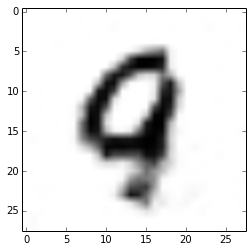

(<matplotlib.image.AxesImage at 0x7f1135fc0c50>, None)

In [18]:
# z = np.random.random((batch_size,z_dim))
z = np.random.normal(0, 1, (1, z_dim))

feed_dict = {z_placeholder: z}

sample = sess.run(adversial_net.sample_gen, feed_dict)

sample_image = sample.reshape((28,28))
# sample_image = (sample_image + 1.0)/ 2.0
%matplotlib inline
import pylab
import matplotlib.pyplot as plt

pylab.imshow(sample_image, cmap=plt.cm.gray_r), pylab.show()

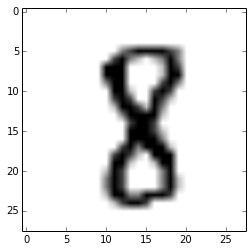

(<matplotlib.image.AxesImage at 0x7f1135f01450>, None)

In [19]:
pylab.imshow((xs[3].reshape((28,28))), cmap=plt.cm.gray_r), pylab.show()

In [20]:
test_x_placeholder = tf.placeholder(tf.float32, [None, input_dim]) 

In [21]:
limit_size = 500
cross_val = 10
sigma_start = -1.0
sigma_end = 0.0

In [40]:
 # generate samples
num_samples = 5000
z = np.random.normal(0, 1, (num_samples, z_dim))
feed_dict = {z_placeholder: z}
samples = sess.run(adversial_net.sample_gen, feed_dict)
samples = ((samples + 1.0) / 2.0)

In [41]:
# cross validate sigma
def get_valid(limit_size = -1):
    data = mnist.validation.images
    return data[:limit_size]
valid = get_valid(limit_size = limit_size)
# valid = 255.0 * valid
# valid = 2.0 * valid - 1.0

In [42]:
sigma_range = np.logspace(sigma_start, sigma_end, num=cross_val)

In [43]:
def log_mean_exp(a):
    """
    Inspired from https://github.com/goodfeli/adversarial/blob/master/parzen_ll.py
    """
    max_ = tf.reduce_max(a, axis=1)
    max_ = tf.expand_dims(max_, -1)
    return max_ + tf.log(tf.reduce_mean(tf.exp(a - max_), axis=1))

In [44]:
def parzen(x, mu, sigma):
    """
    Inspired from https://github.com/goodfeli/adversarial/blob/master/parzen_ll.py
    """
    x = tf.expand_dims(x, dim=1)  ### N1*D -->  N1*1*D
    mu = tf.convert_to_tensor(mu)  ###  Array --> Tensor
    mu = tf.expand_dims(mu, dim=0)  ### N2*D -->  1*N2*D
    a = (x - mu) / sigma           ### N1 * N2 * D (Broadcast subtract)
    E = log_mean_exp(tf.reduce_sum(-0.5 * (a**2), axis=2))
    Z = mu.get_shape().as_list()[2] * tf.log(sigma * tf.sqrt(np.pi * 2))
    ll = E-Z 
    return ll



In [45]:
def get_nll(x, pll, session, batch_size=10):
    """
    Inspired from https://github.com/goodfeli/adversarial/blob/master/parzen_ll.py
    """
    inds = range(x.shape[0])
    n_batches = int(np.ceil(float(len(inds)) / batch_size))
    times = []
    nlls = []
    for i in range(n_batches):
        begin = time.time()
        feed_dict = {test_x_placeholder: x[inds[i::n_batches]]}
        nll = session.run(pll, feed_dict)
        end = time.time()
        times.append(end-begin)
        nlls.extend(nll)
        
        if i % 10 == 0:
            print i, np.mean(times), np.mean(nlls)
    return np.array(nlls)

In [46]:
def cross_validate_sigma(samples, valid_data, session, sigmas, batch_size):
    """
    Inspired from https://github.com/goodfeli/adversarial/blob/master/parzen_ll.py
    """
    lls = []
    for sigma in sigmas:
        print sigma
        pll = parzen(test_x_placeholder, samples, sigma)
        tmp = get_nll(valid_data, pll, session, batch_size = batch_size)
        lls.append(np.asarray(tmp).mean())
    ind = np.argmax(lls)
    return sigmas[ind]

In [47]:
sigma = cross_validate_sigma(samples, valid, sess, sigma_range, batch_size)

0.1
0 0.252230882645 -246.691
0.129154966501
0 0.228891134262 82.5989
0.16681005372
0 0.230335950851 199.671
0.215443469003
0 0.225505113602 189.525
0.278255940221
0 0.225568056107 103.119
0.35938136638
0 0.232905864716 -28.992
0.464158883361
0 0.228563070297 -188.487
0.599484250319
0 0.229223966599 -364.365
0.774263682681
0 0.239172935486 -550.007
1.0
0 0.238841056824 -741.408


In [48]:
# fit and evaulate
# parzen = theano_parzen(samples, sigma)
test = mnist.test.images
# test = 255.0 * test
# test = 2.0 * test - 1.0
pll = parzen(test_x_placeholder, samples, sigma)
# ll = get_nll(test.X, parzen, batch_size = batch_size)
ll = get_nll(test, pll, sess, batch_size = batch_size)
se = (ll).std() / np.sqrt(mnist.test.num_examples/2)

print "Log-Likelihood of test set = {}, se: {}".format(ll.mean(), se)

0 0.399158000946 172.692
10 0.16344813867 184.486
20 0.152263516471 180.12
30 0.148313776139 179.406
40 0.146242833719 182.658
50 0.145007904838 181.929
60 0.144167321627 181.709
70 0.143571964452 180.523
80 0.143118746487 181.941
90 0.142751753985 183.312
Log-Likelihood of test set = 182.635223389, se: 3.17527586211
